In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import time
import torch
import pylab as plt
# %matplotlib inline
# %matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import memory as mem   
from feedforward import Feedforward

## Helper Functions

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action/(self.bins-1.0)*(self.orig_action_space.high-self.orig_action_space.low)  

# DQN

Complete the implemenation of DQN with a main Q-network and a target Q-network

In [4]:
""" Q Network, input: observations, output: q-values for all actions """
class QFunction(Feedforward):
    def __init__(self, observation_dim, action_dim, 
                 hidden_sizes=[100,100], learning_rate = 0.0002):
        super().__init__(input_size=observation_dim, 
                         hidden_sizes=hidden_sizes, 
                         output_size=action_dim)
        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        # The L1 loss is often easier for choosing learning rates etc than for L2 (MSELoss)
        #  Imagine larger q-values (in the hundreds) then an squared error can quickly be 10000!, 
        #  whereas the L1 (absolute) error is simply in the order of 100. 
        self.loss = torch.nn.SmoothL1Loss()
        
    def fit(self, observations, actions, targets):
        # TODO: complete this

        self.train()
        self.optimizer.zero_grad()
        Q_pred = self.Q_value(observations, actions)
        loss = self.loss(Q_pred, torch.from_numpy(targets).float())
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def Q_value(self, observations, actions):
        # compute the Q value for the give actions
        # Hint: use the torch.gather function select the right outputs 
        # Complete this
        output = self.forward(torch.from_numpy(observations).float())
        Q_pred = torch.gather(output, 0, torch.from_numpy(actions).long())
        return Q_pred        
    
    def maxQ(self, observations):
        # compute the maximal Q-value
        # Complete this
        return np.max(self.predict(observations), axis=-1)
    
    def greedyAction(self, observations):
        # this computes the greedy action
        return np.argmax(self.predict(observations), axis=-1)

In [6]:
class DQNAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.05,            # Epsilon in epsilon greedy policies                        
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002, 
            # add additional parameters here        
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
        
        # complete here
        self.train_iter = 0
        self.Q = QFunction(observation_dim = self._observation_space.shape[0],
                           action_dim = self._action_n)
        self.target_Q = QFunction(observation_dim = self._observation_space.shape[0],
                           action_dim = self._action_n)
        self._update_target_net()
            
    def _update_target_net(self):        
        # complete here
        # Hint: use load_state_dict() and state_dict() functions
        model_state = self.Q.state_dict()
        model_state_copy = model_state.copy()
        self.target_Q.load_state_dict(model_state_copy)
        # pass
    
    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        # complete this! 
        # Hint: look at last exercise's solution
        # Hint: while developing print the shape of !all! tensors/arrays to make sure 
        #  they have the right shape: (batchsize, X)  
        
        # Hint: for the target network, update its parameters at the beginning of this function 
        # every k  train calls. 

        # hide this for no target network
        if (self.train_iter+1) % 20 == 0: # change divisor to change how often target network is updated
            self._update_target_net()
        
        # Hint:
        for i in range(iter_fit):
            
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            sp = np.stack(data[:,3]) # s_t+1
            actions = np.stack(data[:,1])[:,None] # a_t
            rew = np.stack(data[:,2])[:,None] # rew
            done = np.stack(data[:,4])[:,None] # done flag
            
            # predict Q_values with current Q network
            Q_values = self.Q.Q_value(s, actions)
            # Q_max = self.Q.maxQ(sp)[:,None] # for no target network
            Q_max = self.target_Q.maxQ(sp)[:,None] # with target network
            # target
            td_target = rew+(1-done)*self._config['discount']*Q_max
            
            # optimize the objective
            fit_loss = self.Q.fit(s, actions, td_target)
            losses.append(fit_loss)  

        self.train_iter+=1
            
        return losses

## Test in Env

In [7]:
env_name = 'Pendulum-v1'
# env_name = 'CartPole-v1'

env = gym.make(env_name)
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

Discrete(5)
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
[(np.float32(-1.0), np.float32(1.0)), (np.float32(-1.0), np.float32(1.0)), (np.float32(-8.0), np.float32(8.0))]


In [8]:
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2)

In [9]:
ob,_info = env.reset()
q_agent.Q.predict(ob)

array([-0.01944377, -0.04399448,  0.01335254, -0.03837093, -0.02697176],
      dtype=float32)

Train the agent!

In [10]:
stats = []
losses = []

In [11]:
max_episodes=600
max_steps=500 
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

1: Done after 500 steps. Reward: -4335.520427094058
21: Done after 500 steps. Reward: -3523.7632578185176
41: Done after 500 steps. Reward: -4202.9952344104395
61: Done after 500 steps. Reward: -3321.7870723487213
81: Done after 500 steps. Reward: -3268.839920657376
101: Done after 500 steps. Reward: -2887.637490638374
121: Done after 500 steps. Reward: -3248.6314679492884
141: Done after 500 steps. Reward: -3698.361374770892
161: Done after 500 steps. Reward: -3030.665192127767
181: Done after 500 steps. Reward: -3134.108000964931
201: Done after 500 steps. Reward: -3271.0282139959286
221: Done after 500 steps. Reward: -4383.24342852563
241: Done after 500 steps. Reward: -2809.806392130598
261: Done after 500 steps. Reward: -3293.282968519382
281: Done after 500 steps. Reward: -3454.0919224032914
301: Done after 500 steps. Reward: -4226.18268982851
321: Done after 500 steps. Reward: -3252.8769735564397
341: Done after 500 steps. Reward: -3185.8768556911396
361: Done after 500 steps. R

Plot the training reward over time. Use the running_mean(array, window_size) to plot a smooth version 

Text(0.5, 0, 'training episodes')

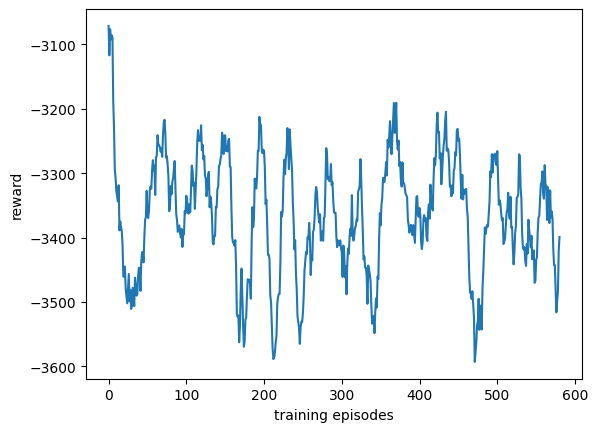

In [19]:
stats_np = np.asarray(stats) # reward
running_mean_stats = running_mean(stats_np[:, 1], 20)
plt.plot(running_mean_stats)
plt.ylabel('reward')
plt.xlabel('training episodes')

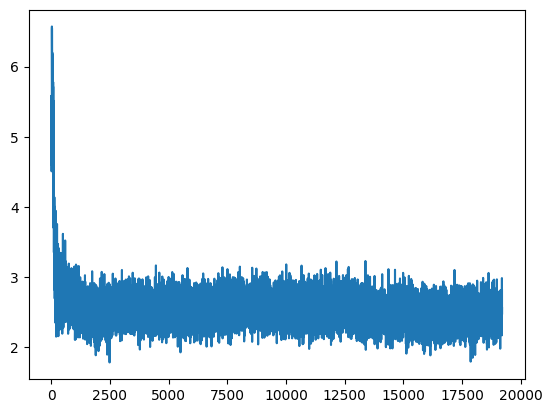

In [20]:
losses_np = np.asarray(losses)
plt.plot(losses_np)

In [21]:
q_agent.buffer.size

100000

## Evaluate (without exploration)

Please look at the behavior for a small number of episodes

In [22]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [23]:
test_stats = []
episodes=50
env_ = env    # without rendering
#env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1])        

Evaluate mean and standard deviation of performance 

(for the Pendulum: an average return around -30 or better should be achieved)

(for the CartPendulum it is possible to get 200)

Text(0.5, 0, 'test episodes')

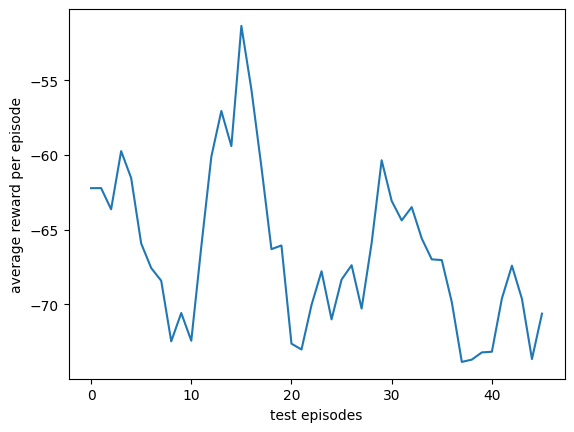

In [25]:
test_stats_np = np.asarray(test_stats) # reward
running_mean_test_stats = running_mean(test_stats_np[:, 1]/50, 5)
plt.plot(running_mean_test_stats)
plt.ylabel('average reward per episode')
plt.xlabel('test episodes')

# Visualize

Visualization of the value function.

In [30]:
def plot_value_function(Q_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-8,8)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([np.cos(XX.ravel()),np.sin(XX.ravel()),YY.ravel()]).T
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values = Q_function.maxQ(dots).reshape(XX.shape)
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=30, azim=45, roll=0)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

## Pendulum Env

Observation space:

0 angle

1 angular velocity

Do that for the pendulum function. Does it look like you expect?

In [31]:
plot_value_function(q_agent.Q)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2500x3 and 4x100)

## Cartpole Env

Observation space:
 
0       Cart Position             -4.8                    4.8

1       Cart Velocity             -Inf                    Inf

2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)

3       Pole Angular Velocity     -Inf                    Inf

Try to adapt the plotting function that it also works in higher input spaces where all other inputs are 0

In [ ]:
def plot_Q_function_generic(Q_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-8,8)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([np.cos(XX.ravel()),np.sin(XX.ravel()),YY.ravel()]).T
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values = Q_function.maxQ(dots).reshape(XX.shape)
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=30, azim=45, roll=0)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=2, 
                       label_dim1="Cart Pos", label_dim2="Pole Angle")

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=1, 
                       label_dim1="Cart Pos", label_dim2="Cart Vel")

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=2, plot_dim2=3, 
                       label_dim1="Pol Angle", label_dim2="Pole Vel")

In [ ]:
%matplotlib notebook

In [ ]:
# env_name = 'Acrobot-v1'
# env_name = 'MountainCar-v0'
# env_name = 'LunarLander-v2'